#!/usr/bin/env python
# coding: utf-8

# # 0619. Subject 2. Read CAN data
# 
# ## 科目２（クラスタリング）
# 
# (Block 1 - 2) CANデータの１ファイルを読む。
# (Block 3 - 5) 550特徴のうちのユニーク種類数1の450特徴を除去。
# (Block 6 - 8) 来週以降のリサンプリングの準備で各特徴のサンプリング周波数を調査。
# (Block 9 - 10) 自己相関を利用して繰り返しパターンの特徴を見つけていく。
# 
# ## 0625
# 
# (Block B01 - B02) 全104変数に自己相関を実施
# (Block B03 - B05) 特徴ごとのプロフィールをCSVに書き込み
# (Block B06 - B08) リサンプリング、線形補間
# (Block B09 - B12) グラフ描画
# (Block B13) ピクルス保存

In [1]:
# %% 
# Block 1. モジュール読みこみ
import os
import os.path
import pickle
from scipy import signal, interpolate
import statsmodels.api as sm 
import copy
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import pathlib
print("done")

done


In [2]:
# %%
# Block 2A
# os.chdir('/home/user01/Documents/project/suzuki_analytics/phase_2/notebooks')
strCurrentDirectory = os.getcwd() 
print(strCurrentDirectory)

# "notebooks"ディレクトリよりも一階層上にいる場合はNotebooksフォルダに移動
if (strCurrentDirectory[-len("notebooks"):] != "notebooks") and ( any("notebooks" in s for s in os.listdir() ) ):
    os.chdir('notebooks')
    strCurrentDirectory = os.getcwd() 
    print("notebooksフォルダの一階層上にいたのでnotebooksフォルダに移動しました。")

if strCurrentDirectory[-len("notebooks"):] == "notebooks":
    print("正常。作業ディレクトリがnotebooksフォルダに設定されています。")
else:
    print("エラー。作業ディレクトリがnotebooks以外に設定されています！現在の作業ディレクトリは" + strCurrentDirectory )

/home/user01/Documents/project/suzuki_analytics/phase_2/notebooks
正常。作業ディレクトリがnotebooksフォルダに設定されています。


In [4]:
# %% 
# Block 2B.  初期状態を読み込み
isSavePickle = 1
import subject2initial

print(subject2initial.strInitialTest)
PATH_DATA_INT = subject2initial.funIsDirMakeDir(strPath  = "../data/interim/")
PATH_DATA_PRO = subject2initial.funIsDirMakeDir(strPath  = "../data/processed/")
PATH_DATA_PRO_SUB2 = subject2initial.funIsDirMakeDir(strPath  = "../data/processed/subject02/")
PATH_DATA_PRO_SUB2_PKL = subject2initial.funIsDirMakeDir(strPath  = "../data/processed/subject02/pickle")

threPacCut = subject2initial.threPacCut
sampFreq = subject2initial.sampFreq
print("threPacCut = " + str(threPacCut) )
print("sampFreq = " + str(sampFreq))

done reading initial file
done
イニシャルファイルからのテキスト読み込み
threPacCut = 0.95
sampFreq = 100


In [5]:
# %%　Block 2C. ファイル読み込み
pdCan = pd.read_csv(
    PATH_DATA_INT/"20190605_CAN/103.486_CAR1V21_HDD2/Job1/SUZUKI_YSB-021_MRR_2016-04-20_06-27_0001.BLF.csv",
    header=None,
    names=('vin', 'time1', 'time2', 'feature', 'value'))
pdCan.head()

,vin,time1,time2,feature,value
0,21,201604200627,0.295909,0FA53,0.0
1,21,201604200627,0.295909,0FA57,4.0
2,21,201604200627,0.295909,0FA43,0.0
3,21,201604200627,0.295909,0FA44,0.0
4,21,201604200627,0.295909,0FA45,0.0


In [6]:
# %% 
# Block 3. 500種類のCAN特徴ごとのデータ要素数を数える
print(pdCan['feature'].value_counts().head())
print("")
print(pdCan['feature'].value_counts().describe())

0FA46    59902
0FA45    59902
0FA32    59902
0FA25    59902
0FA26    59902
Name: feature, dtype: int64

count      549.000000
mean     17915.522769
std      21413.348777
min        599.000000
25%       5989.000000
50%       5992.000000
75%      11980.000000
max      59902.000000
Name: feature, dtype: float64


In [7]:
# %% Block 4. このファイル全体での時間軸を確認
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # 表示桁数調整
print(pdCan['time1'].describe())
print("")
print(pdCan['time2'].describe())

count        9835622.000
mean    201604200647.088
std               20.088
min     201604200627.000
25%     201604200627.000
50%     201604200627.000
75%     201604200627.000
max     201604200627.000
Name: time1, dtype: float64

count   9835622.000
mean        299.780
std         172.864
min           0.296
25%         150.100
50%         299.890
75%         449.413
max         599.239
Name: time2, dtype: float64


In [8]:
# %% Block 5. ユニーク値が一種類のカラムは除去。549特徴が104特徴に。
lsNamesFeatureMultiVal = pdCan.groupby(['feature'])['value'].nunique()
lsNamesFeatureMultiVal = lsNamesFeatureMultiVal[lsNamesFeatureMultiVal >= 2]
lsNamesFeatureMultiVal = lsNamesFeatureMultiVal.index.tolist()
lenNamesFeatureMultiVal = len(lsNamesFeatureMultiVal)
print(lsNamesFeatureMultiVal)
print(lenNamesFeatureMultiVal)

['0FA37', '0FA57', '11451', '11467', '11913', '11915', '11927', '11947', '11F47', '11F53', '12013', '12033', '12051', '12217', '12227', '12231', '12247', '12417', '12437', '12457', '12461', '12464', '12905', '12925', '12944', '12947', '12964', '13F17', '13F47', '13F57', '1AC07', '1AC22', '1AC27', '1AC41', '1AF23', '1AF25', '1AF67', '1B805', '1B825', '1B845', '1B865', '1E303', '1E307', '1E823', '1E843', '1E906', '1E926', '1E946', '1E966', '1EF03', '1EF17', '1EF37', '1EF57', '1EF61', '1EF64', '2A006', '2A026', '2A046', '2A066', '2A214', '31017', '31417', '31434', '31457', '31801', '31802', '31814', '31827', '32F20', '32F25', '32F44', '32F47', '3A105', '3A107', '3A116', '3A211', '3A977', '3B801', '3B947', '3B957', '3BA07', '3BA37', '3BA43', '3BA46', '3BA60', '3C111', '3C112', '3C367', '3D014', '3D016', '3D046', '3D047', '3D052', '3D055', '3D064', '3D151', '3D157', '3D177', '3D604', '3D667', '3E206', '3E801', '46003', '50007']
104


In [9]:
# %% Block 6. 縦持ちデータを横持ちに
pdCanMultiVal = pdCan[pdCan['feature'].isin(lsNamesFeatureMultiVal)]
print(pdCan.shape)
print(pdCanMultiVal.shape)

(9835622, 5)
(3062325, 5)


In [10]:
# %% Block 7. レコード間の時間差をDiffで確認
pdCanMultiVal = pdCanMultiVal.sort_values(
    by=['feature', 'time1', 'time2', 'value'])
pdCanMultiVal['diffTime2'] = pdCanMultiVal.groupby(
    ['feature'])['time2'].diff()  # .fillna(0)
print(pdCanMultiVal.head())

     vin         time1  time2 feature  value  diffTime2
9     21  201604200627  0.296   0FA37  2.000        nan
146   21  201604200627  0.306   0FA37  3.000      0.010
397   21  201604200627  0.316   0FA37  0.000      0.010
644   21  201604200627  0.326   0FA37  1.000      0.010
815   21  201604200627  0.336   0FA37  2.000      0.010


          min     max
count 104.000 104.000
mean    0.040   0.063
std     0.102   0.103
min     0.008   0.011
25%     0.009   0.012
50%     0.010   0.022
75%     0.022   0.103
max     0.998   1.001


(array([28., 24.,  4.,  0.,  0.,  0.,  0.,  2.,  0.,  6., 11.,  1.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5., 11.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

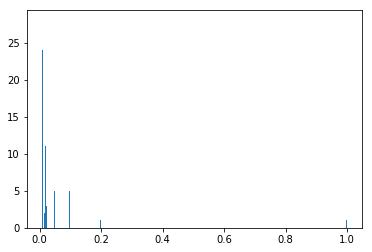

In [11]:
# %%
# Block 8. 特徴毎に時間スパン最小値を探す
pdSpanMinMaxMultiVal = pdCanMultiVal.groupby(
    ['feature'])['diffTime2'].agg(['min', 'max'])
print(pdSpanMinMaxMultiVal.describe())
plt.hist(pdSpanMinMaxMultiVal['min'], bins=1000)
# 104特徴は0.007秒間隔から1.00秒間隔の間。0.010秒間隔でリサンプリングしていく。

count   59901.000
mean        0.010
std         0.000
min         0.009
25%         0.010
50%         0.010
75%         0.010
max         0.011
Name: diffTime2, dtype: float64


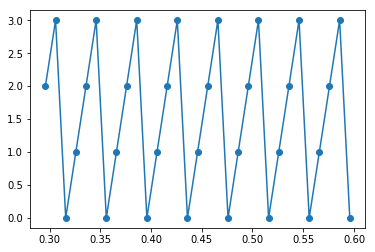

count   5989.000
mean       0.100
std        0.000
min        0.097
25%        0.100
50%        0.100
75%        0.100
max        0.102
Name: diffTime2, dtype: float64


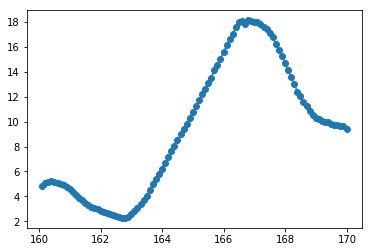

count   5999.000
mean       0.100
std        0.000
min        0.096
25%        0.100
50%        0.100
75%        0.100
max        0.103
Name: diffTime2, dtype: float64


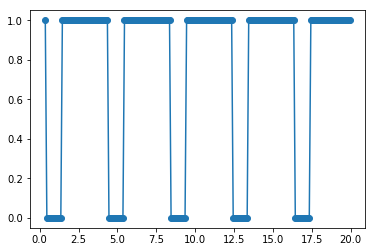

count   29948.000
mean        0.020
std         0.000
min         0.018
25%         0.020
50%         0.020
75%         0.020
max         0.022
Name: diffTime2, dtype: float64


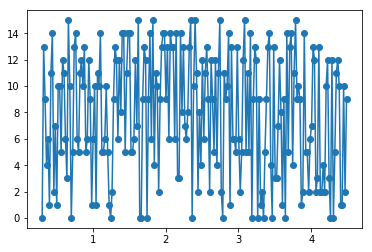

In [12]:
# %%  Block 9. 高い自己相関は除去。パート1．自己相関を一つの特徴で実施
ctFeature = 0 # 61 # 100, 49  # 0
def plotToSeeTimePattern(ctFeature, cutStart, cutEnd):
# if 1:
    thisFeature = lsNamesFeatureMultiVal[ctFeature]
    pdCanMultiValOne = pdCanMultiVal[pdCanMultiVal["feature"] == thisFeature]
    pdCanMultiValOne.head()
    indStart = np.where(pdCanMultiValOne['time2'] >= cutStart)[0][0]
    indEnd = np.where(pdCanMultiValOne['time2'] >= cutEnd)[0][0]
    plt.plot(pdCanMultiValOne['time2'][indStart:indEnd],
            pdCanMultiValOne['value'][indStart:indEnd], "-o")
    print(pdCanMultiValOne["diffTime2"].describe())
    plt.show()

plotToSeeTimePattern(ctFeature = 0, cutStart = 0, cutEnd = 0.6)
plotToSeeTimePattern(ctFeature = 61, cutStart = 160, cutEnd = 170)
plotToSeeTimePattern(ctFeature = 100, cutStart = 0, cutEnd = 20)
plotToSeeTimePattern(ctFeature = 49, cutStart = 0, cutEnd = 4.5)
# 記録間隔はほぼ一定（0.197秒から0.202秒の間）なので、等間隔とみなして波形分析を実施。

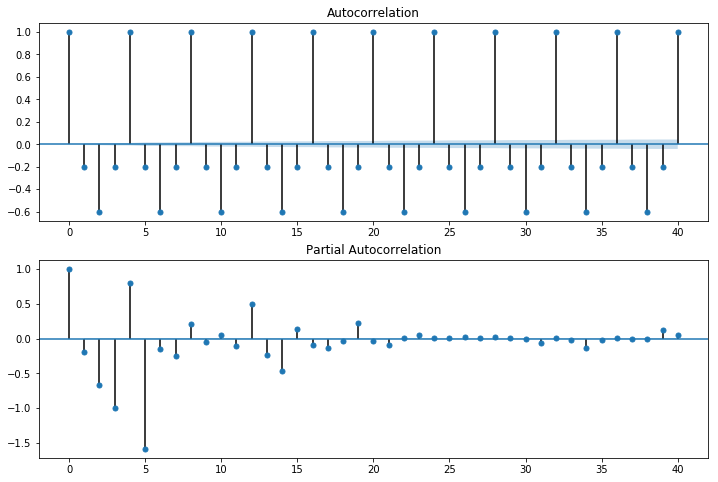

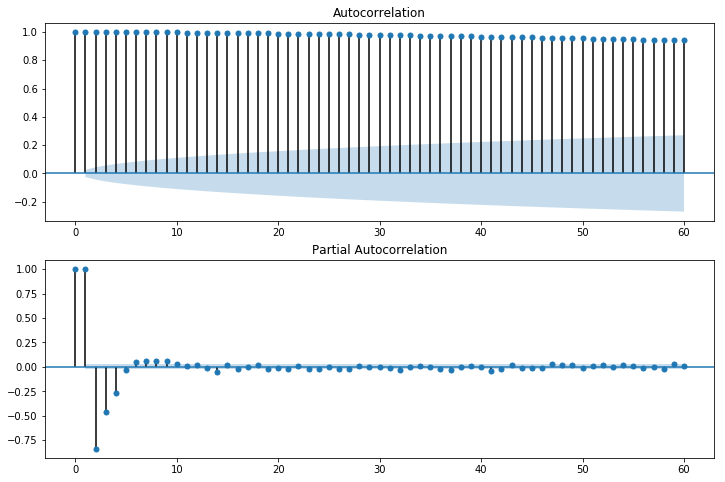

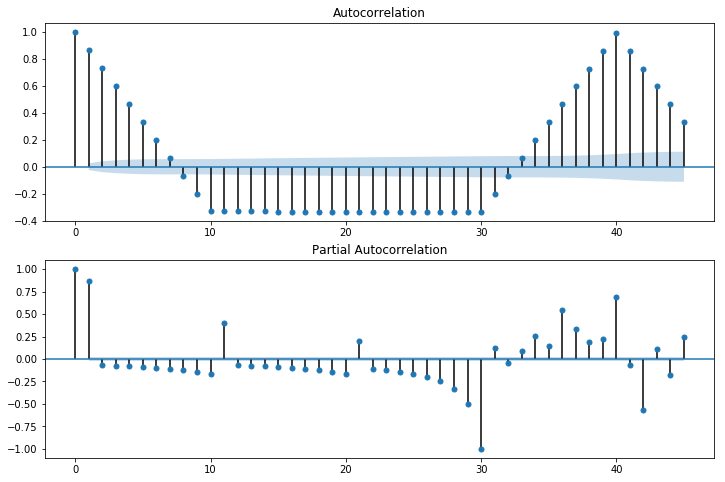

In [13]:
# %%  Block 10. 自己相関のグラフ
def plotAutoCorrelation(ctFeature, myLag2):
    thisFeature = lsNamesFeatureMultiVal[ctFeature]
    pdCanMultiValOne = pdCanMultiVal[pdCanMultiVal["feature"] == thisFeature]
    timeSpanInFeatureMinMax = pdCanMultiValOne["diffTime2"].agg(["min", "max"])
    myTimeSeriesData = pdCanMultiValOne['value']
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(myTimeSeriesData, lags=myLag2, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(
        myTimeSeriesData, lags=myLag2, ax=ax2, method='ols')

plotAutoCorrelation(ctFeature = 0, myLag2 = 40)
plotAutoCorrelation(ctFeature = 61, myLag2 = 60)
plotAutoCorrelation(ctFeature = 100, myLag2 = 45)
# plotAutoCorrelation(ctFeature = 49, myLag2 = 200) # 3分位掛かるので普段は実行しない。


# # 0625

In [18]:
# %% 
# block B01. 高い自己相関は除去。パート３．自己相関を全変数まわす計算のみ。（10分間程度かかる）
ctFeature = 61 # 100 # 3
myLag = 10 # 自己相関ラグは10あれば今ファイルのたいていの自己相関が検出可能。
myLag40 = 45 # 100番目の変数だけはラグ40程度必要。
threLag = 3 # このラグ以上のラグの中で最大の偏自己相関を分析に使用。
lsTimeSpanInFeatureMinMax = list()
lsTsPacf = list()

for ctFeature in list(range(lenNamesFeatureMultiVal)):
# if 1:
    thisFeature = lsNamesFeatureMultiVal[ctFeature]
    pdCanMultiValOne = pdCanMultiVal[pdCanMultiVal["feature"] == thisFeature]
    timeSpanInFeatureMinMax = pdCanMultiValOne["diffTime2"].agg(["min", "max"])
    myTimeSeriesData = pdCanMultiValOne['value']
    myLag2 = myLag if not ctFeature == 100 else myLag40
    ts_acf = sm.tsa.stattools.acf(myTimeSeriesData, nlags=myLag2)
    ts_pacf = sm.tsa.stattools.pacf(
        myTimeSeriesData, nlags=myLag2, method='ols')    # 偏自己相関
    lsTimeSpanInFeatureMinMax.append(timeSpanInFeatureMinMax)
    lsTsPacf.append(ts_pacf)
    tempMax = round(abs(ts_pacf[threLag:]).max(), 2)
    tempMax = pd.Series([tempMax, 1]).min()
    print("ctFeature=" + str(ctFeature) + " " +
          "minSpan/maxSpan=" + str(round(timeSpanInFeatureMinMax[0] / timeSpanInFeatureMinMax[1], 2)) + " " +
          "maxPAC_after_2lag=" + str(tempMax) + " " +
          thisFeature)

print(len(lsTsPacf))
print(abs(ts_pacf))

ctFeature=0 minSpan/maxSpan=0.89 maxPAC_after_2lag=1.0 0FA37
ctFeature=1 minSpan/maxSpan=0.89 maxPAC_after_2lag=1.0 0FA57
ctFeature=2 minSpan/maxSpan=0.9 maxPAC_after_2lag=1.0 11451
ctFeature=3 minSpan/maxSpan=0.9 maxPAC_after_2lag=1.0 11467
ctFeature=4 minSpan/maxSpan=0.88 maxPAC_after_2lag=0.62 11913
ctFeature=5 minSpan/maxSpan=0.88 maxPAC_after_2lag=1.0 11915
ctFeature=6 minSpan/maxSpan=0.88 maxPAC_after_2lag=0.52 11927
ctFeature=7 minSpan/maxSpan=0.88 maxPAC_after_2lag=0.52 11947
ctFeature=8 minSpan/maxSpan=0.85 maxPAC_after_2lag=1.0 11F47
ctFeature=9 minSpan/maxSpan=0.85 maxPAC_after_2lag=1.0 11F53
ctFeature=10 minSpan/maxSpan=0.79 maxPAC_after_2lag=0.13 12013
ctFeature=11 minSpan/maxSpan=0.79 maxPAC_after_2lag=0.19 12033
ctFeature=12 minSpan/maxSpan=0.79 maxPAC_after_2lag=1.0 12051
ctFeature=13 minSpan/maxSpan=0.76 maxPAC_after_2lag=0.45 12217
ctFeature=14 minSpan/maxSpan=0.76 maxPAC_after_2lag=0.8 12227
ctFeature=15 minSpan/maxSpan=0.76 maxPAC_after_2lag=1.0 12231
ctFeature=16 m

In [21]:
# %%
# Block B02. パターン度合い得点（ 自己相関の結果を利用）を集計

# method A (内包記法)（Method Bにも書き換え可能）
lsPacfAcrossFeatures = [ abs(ts_pacf[threLag:]).max() if abs(ts_pacf[threLag:]).max()  <= 1 else 1 for ts_pacf in lsTsPacf]

if 0: # このセクションは実行していない
    # method B (FOR文)（Method Aにも書き換え可能）
    lsPacfAcrossFeatures = list()
    for ctFeature in list(range(len(lsTsPacf))):
        ts_pacf = lsTsPacf[ctFeature]
        maxPac = abs(ts_pacf[threLag:]).max()
#         tempMax = pd.Series([tempMax, 1]).min()
        maxPac = maxPac if maxPac <= 1 else 1
        lsPacfAcrossFeatures.append(maxPac)

# print(lsPacfAcrossFeatures)
pdPacfAcrossFeatures = pd.DataFrame(lsPacfAcrossFeatures)
pdPacfAcrossFeatures.columns = ['maxAbsPAC']
pdPacfAcrossFeatures.index = lsNamesFeatureMultiVal
print(pdPacfAcrossFeatures)
pdPacfAcrossFeatures.to_csv(PATH_DATA_PRO_SUB2/"pdPacfAcrossFeatures_Ubuntu.csv")


       maxAbsPAC
0FA37      1.000
0FA57      1.000
11451      1.000
11467      1.000
11913      0.618
11915      1.000
11927      0.515
11947      0.515
11F47      1.000
11F53      1.000
12013      0.127
12033      0.187
12051      1.000
12217      0.445
12227      0.798
12231      1.000
12247      0.220
12417      0.482
12437      0.068
12457      0.220
12461      1.000
12464      0.001
12905      0.064
12925      0.004
12944      0.023
12947      1.000
12964      0.023
13F17      0.569
13F47      0.384
13F57      0.500
...          ...
3A116      0.003
3A211      1.000
3A977      0.057
3B801      0.001
3B947      0.009
3B957      0.000
3BA07      0.001
3BA37      0.010
3BA43      0.006
3BA46      0.011
3BA60      0.003
3C111      0.437
3C112      0.002
3C367      0.068
3D014      0.015
3D016      0.000
3D046      0.686
3D047      0.523
3D052      0.002
3D055      0.001
3D064      0.000
3D151      0.389
3D157      0.000
3D177      0.276
3D604      0.015
3D667      0.000
3E206      1.0

In [22]:
# %%
# Block B03. カラム名を読み込み
# print(os.getcwd())
# featureName
pdKeyName = pd.read_csv(
    PATH_DATA_INT/"20190605_CAN/20190617_featureName.csv") 
pdKeyName.head()

,key,featureName
0,sc11947,Steering Wheel Absolute Angle
1,sc12013,Engine Torque Actual
2,sc12217,Accelerator Actual Position
3,sc12417,Engine Speed
4,sc1AF67,Master Cylinder Pressure


In [25]:
# %%
# Block B04
# feature profiling
pdFeatureProfile = pd.DataFrame(sorted(pdCan['feature'].unique()))
pdFeatureProfile.columns = ['feature']

In [26]:
# %%
# Block B05
# feature profiling
pdFeatureProfile = pd.DataFrame(sorted(pdCan['feature'].unique()))
pdFeatureProfile.columns = ['feature']

# merge with key
pdFeatureProfile['key'] = "sc" + pdFeatureProfile['feature']
pdFeatureProfile = pd.merge(pdFeatureProfile, pdKeyName, how = 'left')
pdFeatureProfile['featureName2'] = pdFeatureProfile['featureName']
pdFeatureProfile['featureName2'].iloc[np.where(pd.isnull( pdFeatureProfile['featureName'] ))] = "No_Name"

# pdFeatureProfile['featureName'] = "未定義"

# ラベル付
pdFeatureProfile['isinThisFile'] = 1
pdFeatureProfile['isMultiValOf104'] = pdFeatureProfile['feature'].isin(lsNamesFeatureMultiVal) * 1 # boolを01に変換

# merge with Partial Auto Correlation
pdPacfAcrossFeatures2 = copy.deepcopy(pdPacfAcrossFeatures)
pdPacfAcrossFeatures2["feature"] = pdPacfAcrossFeatures2.index.tolist()
pdFeatureProfile = pd.merge(pdFeatureProfile, pdPacfAcrossFeatures2, how = 'left')
pdFeatureProfile['isRemoveDueToPAC'] = [ 1 if myVal > threPacCut else 0 for myVal in pdFeatureProfile['maxAbsPAC'] ]

# 内容確認
pdFeatureProfile.describe()
pdFeatureProfile.head(30)
valTotalNoName = pdFeatureProfile['featureName'].isnull().sum()
print(
    str(len(pdFeatureProfile.index)) + "特徴の中の" +
    str(valTotalNoName) + "は名称未定義" + str(valTotalNoName/ len(pdFeatureProfile.index)) + "％" )

pdFeatureProfile.to_csv( PATH_DATA_PRO_SUB2/"0624_pdFeatureProfile.csv")

549特徴の中の513は名称未定義0.9344262295081968％


In [27]:
# %% 
# Block B06. このファイル内の使用項目全104特徴をカバーする時間軸を作る.評価スパンで終端除去
timeSpan = 1 / sampFreq # サンプリング周波数は100か1000を検討中（6月18日）。subject2initial.pyで定義。
timeSeriesStart = timeSpan
pdCanMultiVal['timeAdj'] = pdCanMultiVal['time2'] 
timeEvalSpan = 1.000  # 評価スパンは１秒間隔
pdCanMultiVal['timeAdj'].agg(['min', 'max'])
timeSeriesEnd = timeSpan * math.ceil(pdCanMultiVal['timeAdj'].max()/timeSpan)
timeSeriesEndFloor = timeEvalSpan *     math.floor(timeSeriesEnd / timeEvalSpan)  # 評価スパンで終端除去　
timeSeriesStart2End = np.arange(
    timeSeriesStart, (timeSeriesEndFloor + timeSpan), timeSpan)
print(pd.Series(timeSeriesStart2End).describe())
timeSeriesStart2End[:10]

count   59900.000
mean      299.505
std       172.918
min         0.010
25%       149.757
50%       299.505
75%       449.252
max       599.000
dtype: float64


array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [28]:
# %% 
# Block B07. 補間して全データをtimeSpan秒単位に変換
# 補間ステップ１．内挿を成功させるために開始点（0.00秒目）と終了点(約600秒目)にコピーデータを置く。
lsPdCanThisFeature = list()
ctFeature = 2
for ctFeature in list(range(lenNamesFeatureMultiVal)):
    print(ctFeature)
    # 特徴ひとつだけを抽出
    thisFeature = lsNamesFeatureMultiVal[ctFeature]
    pdCanThisFeature2 = pdCanMultiVal[[
        'timeAdj', 'value']][pdCanMultiVal['feature'] == thisFeature]

    # 内挿補間を動作させるために共通開始時間を挿入
    if(pdCanThisFeature2['timeAdj'].iloc[0] != 0):
        pdCanThisFeature2 = pd.concat(
            [pdCanThisFeature2.head(1), pdCanThisFeature2], axis=0)
        pdCanThisFeature2['timeAdj'].iloc[0] = 0

    # 内挿補間を動作させるために共通終了時間を挿入
    if(pdCanThisFeature2['timeAdj'].iloc[-1] != timeSeriesEnd):
        pdCanThisFeature2 = pd.concat(
            [pdCanThisFeature2, pdCanThisFeature2.tail(1)], axis=0)
        pdCanThisFeature2['timeAdj'].iloc[-1] = timeSeriesEnd

    # 開始時間と終了時間を追加したDFを保存
    lsPdCanThisFeature.append(pdCanThisFeature2)

print(lsPdCanThisFeature[0].head(2))
print(lsPdCanThisFeature[1].head(2))
print(lsPdCanThisFeature[61].head(2))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
   timeAdj  value
9    0.000  2.000
9    0.296  2.000
   timeAdj  value
1    0.000  4.000
1    0.296  4.000
    timeAdj  value
65    0.000  0.000
65    0.298  0.000


In [29]:
# %% 
# Block B08. 補間ステップ２．線形補間で内挿。0.010秒間隔のリサンプリング完了工程。
lsNpCanResampled = list()
ctFeature = 0
for ctFeature in list(range(lenNamesFeatureMultiVal)):
    print(ctFeature)
    pdCanThisFeature2 = lsPdCanThisFeature[ctFeature]
    pdCanThisFeature2.head()
    funInterpolateLinear = interpolate.interp1d(
        pdCanThisFeature2['timeAdj'], pdCanThisFeature2['value'], kind='linear')
    outFunINterpolate = funInterpolateLinear(timeSeriesStart2End)
    lsNpCanResampled.append(outFunINterpolate)

outFunINterpolate = lsNpCanResampled[0]
print(outFunINterpolate[:10])
print(lsNpCanResampled[1][:10])
print(lsNpCanResampled[1][:1000])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[ 4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          4.
  4.          4.          4.          4.          4.          2.36294518
  4.91596639 10.35990797  6.35887177  2.35856414  4.91868132 10.36148919
  6.35812231  2.35616438  4.93129313 10.356       6.35731415  2.35788631
  4.93249325 10.35477739  6.35310593  2.3524      4.9398361  10.35447089
  6.35334134  2.3517407   4.9476     10.35047009  6.35131894  2.35221133
  4.9

In [30]:
# %% 
# Block B09. 描画で実感。
def plotMoire(ctFeature, gridStart=0, gridEnd=0, gridBy=1, myLinewidth = 1, figW=18, figH=6, 
                isInterpolate = 1, isVertical = 1):
# if 1:
    pdCanResampled = lsNpCanResampled[ctFeature]
    pdCanThisFeature2 = lsPdCanThisFeature[ctFeature]
    plt.figure(num=None, figsize=(figW, figH), dpi=80, facecolor='w', edgecolor='k')

    # 生データ
    indStart = np.where(pdCanThisFeature2['timeAdj'] >= gridStart)[0][0]
    indEnd = np.where(pdCanThisFeature2['timeAdj'] >= gridEnd)[0][0]
    timeSeriesStart2End[indStart:indEnd]
    pdCanThisFeature2['timeAdj'][indStart:indEnd]
    plt.plot(pdCanThisFeature2['timeAdj'][indStart:indEnd], pdCanThisFeature2['value'][indStart:indEnd], "o", color = "blue", markersize = 5)

    # interpolate line
    indStart = np.where(timeSeriesStart2End >= gridStart)[0][0]
    indEnd = np.where(timeSeriesStart2End >= gridEnd)[0][0] + 1
    if isInterpolate == 1:
        plt.plot(timeSeriesStart2End[indStart:indEnd],  pdCanResampled[indStart:indEnd], color="dodgerblue", linewidth=myLinewidth)

    # grid
    if isVertical == 0:
        plt.grid()
    else:
        for xc in timeSeriesStart2End[indStart:indEnd]:
            plt.axvline(x=xc, linewidth=0.5, color = "0.6") #, linestyle=":")
    sampFreq
print("done")

done


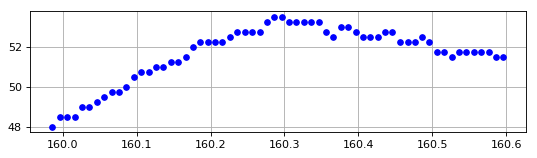

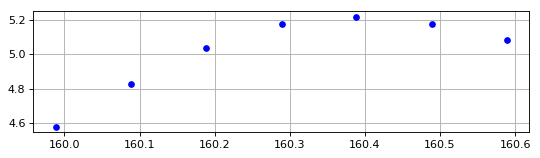

In [31]:
# %%
# Block B10.
# why resampling?
plotMoire(ctFeature = 37, gridStart = 159.98, gridEnd = 160.6, gridBy = timeSpan, 
            myLinewidth = 1, figW = 8, figH = 2, isInterpolate = 0, isVertical = 0)
plotMoire(ctFeature = 61, gridStart = 159.98, gridEnd = 160.6, gridBy = timeSpan, 
            myLinewidth = 1, figW = 8, figH = 2, isInterpolate = 0, isVertical = 0)

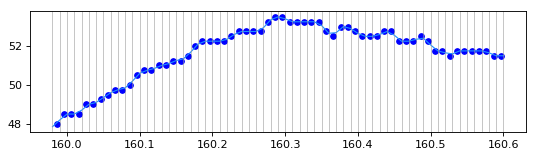

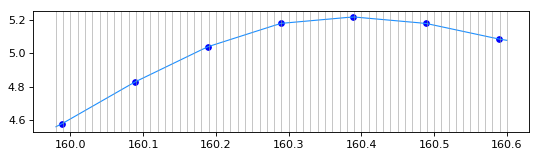

In [32]:
# %%
# Block B11.
# comparison of sampling rates
plotMoire(ctFeature = 37, gridStart = 159.98, gridEnd = 160.6, gridBy = timeSpan, 
            myLinewidth = 1, figW = 8, figH = 2, isInterpolate = 1)
plotMoire(ctFeature = 61, gridStart = 159.98, gridEnd = 160.6, gridBy = timeSpan, 
            myLinewidth = 1, figW = 8, figH = 2, isInterpolate = 1)

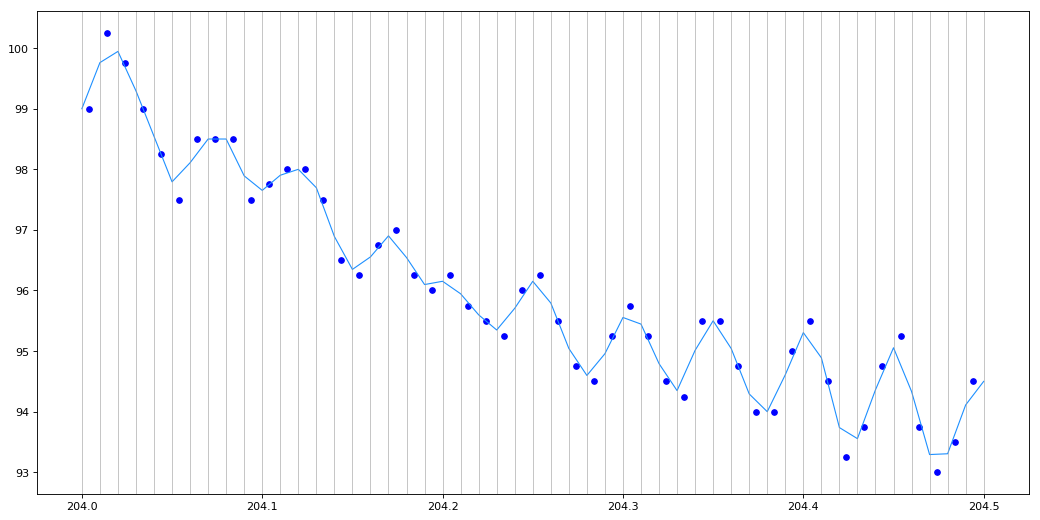

In [33]:
# %%
# Block B12.
# 車輪速を見るとサンプリング周波数が100Hzだと不足。1000Hzのほうが良さそう。
plotMoire(ctFeature = 37, gridStart = 204, gridEnd = 204.5, gridBy = 0.01, myLinewidth = 1, figW = 16, figH = 8, isInterpolate = 1)

In [34]:
# %%
# Block B13 オブジェクトをピクルスで保存

if isSavePickle == 1:
    subject2initial.pickleOneObject(nameObj=lsPdCanThisFeature,   strObj="lsPdCanThisFeature", myPathlib = PATH_DATA_PRO_SUB2_PKL)
    subject2initial.pickleOneObject(nameObj=lsNpCanResampled,   strObj="lsNpCanResampled", myPathlib = PATH_DATA_PRO_SUB2_PKL)
    subject2initial.pickleOneObject(nameObj=timeSeriesStart2End,   strObj="timeSeriesStart2End", myPathlib = PATH_DATA_PRO_SUB2_PKL)
    subject2initial.pickleOneObject(nameObj=lsNamesFeatureMultiVal,   strObj="lsNamesFeatureMultiVal", myPathlib = PATH_DATA_PRO_SUB2_PKL)
    subject2initial.pickleOneObject(nameObj=lsTsPacf,   strObj="lsTsPacf", myPathlib = PATH_DATA_PRO_SUB2_PKL)
    subject2initial.pickleOneObject(nameObj=pdFeatureProfile,   strObj="pdFeatureProfile", myPathlib = PATH_DATA_PRO_SUB2_PKL)
    subject2initial.pickleOneObject(nameObj=pdPacfAcrossFeatures,   strObj="pdPacfAcrossFeatures", myPathlib = PATH_DATA_PRO_SUB2_PKL)

print("done")



#%%

done
